# Intro

Some experiments to get a good score for the [Identify Age-Related Conditions][0] kaggle competition using decision tree models.

Start by importing commonly used modules that make it convenient to work with the fastai library. Some will be patched to make them work in non-standard ways but improve interactivity.

[0]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions

In [2]:
from fastai.imports import *
from fastai.tabular.all import *

# Data Inspection

Get the dataset appropriately whether we're in kaggle or not. If in kaggle, it is assumed the competition dataset has been connected to the notebook.

In [3]:
import os
competition_name = "icr-identify-age-related-conditions"

is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if is_kaggle:
    path = Path(f"/kaggle/input/{competition_name}")
else:
    import zipfile, kaggle
    path = Path.home() / '.kaggle' / 'input' / competition_name
    kaggle.api.competition_download_cli(competition_name, path=path.parent)
    zipfile.ZipFile(f'{path}.zip').extractall(path)

icr-identify-age-related-conditions.zip: Skipping, found more recently modified local copy (use --force to force download)


Load the datasets. It's a small dataset so we can set the `low_memory` pandas flag to `False`.

In [4]:
path.ls()

(#4) [Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/test.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/greeks.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/train.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')]

In [5]:
df_train = pd.read_csv(f'{path}/train.csv', low_memory=False)
df_test = pd.read_csv(f'{path}/test.csv', low_memory=False)
df_train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [6]:
df_train.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

We can now examine the data.

In [7]:
df_train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


We see that the mean of the dependant column `Class` is much closer to zero than one. This means that the observations with a positive diagnosis are smaller in proportion in the training data. We confirm this by plotting a pie chart for column `Class`.

<Axes: ylabel='count'>

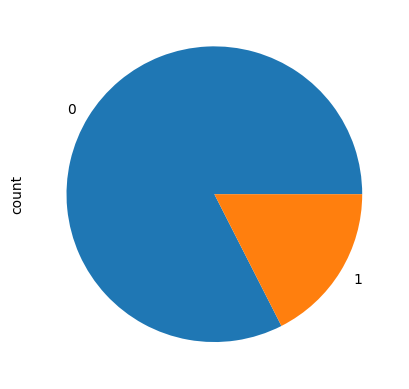

In [8]:
%matplotlib inline

df_train.Class.value_counts().plot.pie()

We also check for null values

In [9]:
df_train.isna().sum()

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

 # Data Processing
 
We'll do some simple processing. We'll replace null values with the mode of their columns, and replace the categorical columns `EJ` and `Id` with numeric codes representing their levels.

In [11]:
modes = df_train.mode().iloc[0]

def process_data(df):
    df.fillna(modes, inplace=True)
    df["EJ"] = pd.Categorical(df.EJ).codes
    df["Id"] = pd.Categorical(df.Id).codes

    
process_data(df_train)
process_data(df_test)

In [13]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    int16  
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      617 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      617 non-null    float64
 17  CC      617 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

(None, None)

# Modelling

Because of the class imbalance, we'll use stratified K-fold for our train/test splits. 

The competition uses the balanced log loss metric which is explained more [here][0]. For our purposes, we'll use the simple implementation.

[0]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/422442

In [14]:
from sklearn.metrics import log_loss
def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

def m_log_loss(model, xs, y): return balanced_log_loss(np.array(y), np.array(model.predict(xs)))

For each fold, we train and validate a model and collect the metrics. To start with, we'll train a simple decision tree classifier to establish a baseline.

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

s_kfold = StratifiedKFold(n_splits=5)

In [57]:
ycol = "Class"

def x_y(df):
    y = df[ycol]
    x = df.drop(columns=ycol)
    return x, y

models, metrics = [], []
for train_idx, valid_idx in s_kfold.split(df_train, df_train.Class):
    train_xy, valid_xy = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    train_x, train_y = x_y(train_xy)
    valid_x, valid_y = x_y(valid_xy)
    
    tree = DecisionTreeClassifier(min_samples_leaf=5)
    tree.fit(train_x, train_y)
    
    metrics.append(m_log_loss(tree, valid_x, valid_y))
    models.append(tree)
    
models, metrics 

([DecisionTreeClassifier(min_samples_leaf=5),
  DecisionTreeClassifier(min_samples_leaf=5),
  DecisionTreeClassifier(min_samples_leaf=5),
  DecisionTreeClassifier(min_samples_leaf=5),
  DecisionTreeClassifier(min_samples_leaf=5)],
 [6.402949614973338,
  7.187921805766765,
  7.647681526044064,
  6.9416442616340674,
  9.094282840550793])

We now have an ensemble of decision trees. We can evaluate them by calculating the average metric.

In [58]:
np.mean(metrics)

7.454896009793805

We can try Random Forests as well to see if there's any improvement.

In [78]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(xs, y, n_estimators=300, max_samples=None, max_features="sqrt", min_samples_leaf=1, **kwargs):
    return RandomForestClassifier(
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        **kwargs
    ).fit(xs, y)

In [83]:

models, metrics = [], []
for train_idx, valid_idx in s_kfold.split(df_train, df_train.Class):
    train_xy, valid_xy = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    train_x, train_y = x_y(train_xy)
    valid_x, valid_y = x_y(valid_xy)
    
    rf = random_forest(train_x, train_y)
    
    metrics.append(m_log_loss(rf, valid_x, valid_y))
    models.append(rf)
    
models, metrics, np.mean(metrics)

([RandomForestClassifier(n_estimators=300, oob_score=True),
  RandomForestClassifier(n_estimators=300, oob_score=True),
  RandomForestClassifier(n_estimators=300, oob_score=True),
  RandomForestClassifier(n_estimators=300, oob_score=True),
  RandomForestClassifier(n_estimators=300, oob_score=True)],
 [9.419666289521098,
  5.725703026888223,
  6.178757335402306,
  8.731453130328285,
  4.450382388674783],
 6.901192434162939)

Let's see how the OOB predictions compare.

In [110]:
models, metrics = [], []
for train_idx, valid_idx in s_kfold.split(df_train, df_train.Class):
    train_xy, valid_xy = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    train_x, train_y = x_y(train_xy)
    valid_x, valid_y = x_y(valid_xy)
    
    rf = random_forest(train_x, train_y, oob_score=True, max_samples=0.8)
    oob_preds = rf.oob_decision_function_
    oob_preds_class_1 = oob_preds[:,1]
    
    metrics.append(balanced_log_loss(train_y, oob_preds_class_1))
    
    models.append(rf)
    
models, metrics, np.mean(metrics)

([RandomForestClassifier(max_samples=0.8, n_estimators=300, oob_score=True),
  RandomForestClassifier(max_samples=0.8, n_estimators=300, oob_score=True),
  RandomForestClassifier(max_samples=0.8, n_estimators=300, oob_score=True),
  RandomForestClassifier(max_samples=0.8, n_estimators=300, oob_score=True),
  RandomForestClassifier(max_samples=0.8, n_estimators=300, oob_score=True)],
 [0.47994783334067165,
  0.4638278920247426,
  0.6447973163823905,
  0.450265433269094,
  0.46852452494911334],
 0.5014725999932024)

The OOB predictions look quite good, and probably closer to the true metric value.


# Model Interpretation

We can now use the random forest ensemble to determine importance of each feature. We'll aggregate the feature importance metrics over all the models.

In [111]:
columns = [c for c in df_train.columns if c != ycol]

importances = [m.feature_importances_ for m in models]
feature_importance = pd.DataFrame(data=importances, columns=columns)
feature_importance = feature_importance.sum().sort_values(ascending=False)
feature_importance

DU     0.482555
FL     0.257018
DA     0.229742
GL     0.216313
CR     0.210678
DI     0.199866
AB     0.167233
DE     0.160595
EH     0.157467
BC     0.153659
FD     0.137543
FR     0.129724
AF     0.123695
CC     0.113993
EE     0.112094
FE     0.109846
DH     0.096186
FI     0.085150
AM     0.083097
DL     0.078397
BR     0.074685
EB     0.070923
CD     0.068854
CU     0.068741
BN     0.062647
DY     0.061068
BP     0.058603
BQ     0.057434
GH     0.056803
AX     0.056246
CF     0.056186
GF     0.056128
CB     0.053337
GB     0.051875
EG     0.050978
FC     0.050091
CS     0.049000
DF     0.048756
DN     0.048628
BD     0.046006
CH     0.045119
GI     0.044389
EU     0.042852
EP     0.041974
AZ     0.040944
Id     0.040059
AR     0.039979
FS     0.036507
EL     0.032981
AH     0.031464
GE     0.027848
CL     0.027112
CW     0.027071
AY     0.025760
BZ     0.020735
DV     0.018279
EJ     0.005089
dtype: float64

We can plot this:


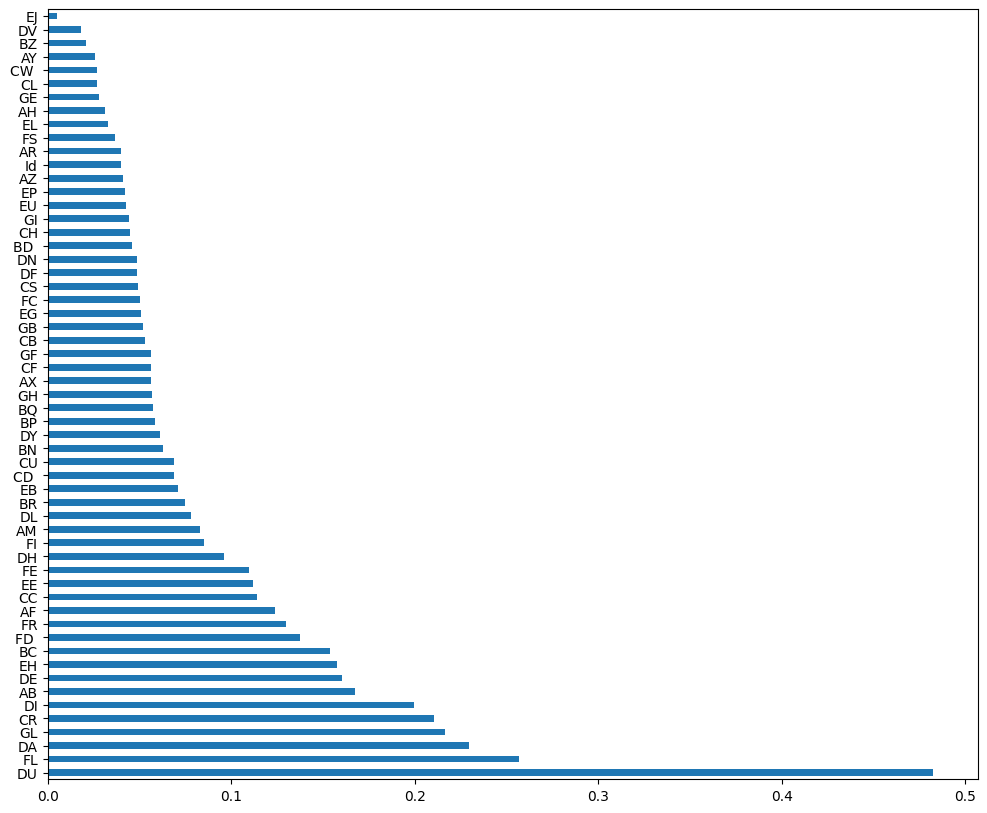

In [112]:
def plot_feature_importance(feature_importance):
    feature_importance.plot(kind='barh', figsize=(12, 10))
    
plot_feature_importance(feature_importance)

At this point we could remove the low importance features. Let's first establish a baseline score with all the columns:

In [114]:
def get_rf_score(df):
    
    models, metrics = [], []
    for train_idx, valid_idx in s_kfold.split(df, df.Class):
        train_xy, valid_xy = df.iloc[train_idx], df.iloc[valid_idx]
        train_x, train_y = x_y(train_xy)
        valid_x, valid_y = x_y(valid_xy)
    
        rf = random_forest(train_x, train_y, oob_score=True)
        oob_preds = rf.oob_decision_function_
        oob_preds_class_1 = oob_preds[:,1]
    
        metrics.append(balanced_log_loss(train_y, oob_preds_class_1))
        
        models.append(rf)
    
    return models, metrics, np.mean(metrics)    

_, _, score = get_rf_score(df_train)
score

0.4699417412350032

Then we can remove some of the low importance columns and see the impact on the score. We know that `Id` should not have much of a predictive value, so any columns with similar importance can be removed.

In [129]:
important_cols = feature_importance[feature_importance > 0.05]
important_cols = list(important_cols.index)
important_cols

['DU',
 'FL',
 'DA',
 'GL',
 'CR',
 'DI',
 'AB',
 'DE',
 'EH',
 'BC',
 'FD ',
 'FR',
 'AF',
 'CC',
 'EE',
 'FE',
 'DH',
 'FI',
 'AM',
 'DL',
 'BR',
 'EB',
 'CD ',
 'CU',
 'BN',
 'DY',
 'BP',
 'BQ',
 'GH',
 'AX',
 'CF',
 'GF',
 'CB',
 'GB',
 'EG',
 'FC']

In [133]:
models, model_scores, score = get_rf_score(df_train[important_cols + [ycol]])
score

0.4806879003707902

It doesn't seem to negatively impact the score

# Submission

We can submit this to kaggle and see how it scores on the leaderboard. We'll get predictions from the ensemble by averaging all the predictions from the individual random forest models.

In [145]:
preds = []
for rf in models:
    preds.append(rf.predict_proba(df_test[important_cols]))
avg_preds = sum(preds) / len(models)
avg_preds

array([[0.50133333, 0.49866667],
       [0.50133333, 0.49866667],
       [0.50133333, 0.49866667],
       [0.50133333, 0.49866667],
       [0.50133333, 0.49866667]])

In [146]:
submit=True
if is_kaggle and submit:
    
    preds = []
    for rf in models:
        preds.append(rf.predict_proba(df_test[important_cols]))
    avg_preds = sum(preds) / len(models)

    df_submission = pd.read_csv(f"{path}/sample_submission.csv")
    df_submission[["class_0", "class_1"]] = avg_preds
    df_submission.to_csv("submission.csv", index=False)

This one scored 0.33, our best yet.